In [1]:
from standardInclude import *

Welcome to JupyROOT 6.20/04
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
path = "/home/jlab/g-2/caloTrackMatching/data/run2c/"; dataset='Run 2C'
#path = "/home/jlab/g-2/caloTrackMatching/data/endgame/"; dataset='EndGame'
#path = "/home/jlab/g-2/caloTrackMatching/data/9day/"; dataset='9 day'
files = os.listdir(path)
print(files)
names = [x.split("_")[0] for x in files]
print(names)

to_fit = "width"

fs = {}
for file in files:
    name = file.split("_")[0]
    fs[name] = r.TFile(path+file)
    fs[name].ls()

['tracks_run2c.root', 'clusters_run2c.root', 'matchedTracks_run2c.root']
['tracks', 'clusters', 'matchedTracks']
TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH2D	trackerDeltaPosition_vs_Time;1	Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation
TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/

In [3]:
allFitResults = {}

In [4]:
station = 12
calo = station+1

---

### First create a function which will act as a standard pool from which we can pull our fit functions, just for ease of switching between them

In [5]:
def fitfunc(choice, fitrange, params=None):
    tlow, thigh = fitrange
    if(choice is 0):
        func = r.TF1("func","[0] + [1] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
        func.SetParNames("C", "A", "#tau", "m")
        if(params is None):
            paramVec = [1,10,1,-0.0001,10]
        else:
            paramVec = params
        for i,xi in enumerate(paramVec):
            func.SetParameter(i,xi)
        return (func,paramVec)
    elif(choice is 1):
        func = r.TF1("func","pol1",tlow,thigh)
        func.SetParNames("C", "m")
        if(params is None):
            params = [1,-0.00001]
        for i,xi in enumerate(params):
            func.SetParameter(i,xi)
        return (func, params)
    else:
        print("Invalid choice")
        return -1

---

# Lets start with the tracker-only information


In [69]:
name = 'tracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
  OBJ: TH3I	trackerBeamPosRand	Tracker Beam Position vs. Rand Time : 0 at: 0x55ceb3dd6c40
  OBJ: TH3I	trackerCaloPosRand	Tracker Calo Face Position vs. Rand Time : 0 at: 0x55ceb3ea4300
  OBJ: TH3I	trackerCaloPos_noRadialField	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x55ceb3eb4ff0
  OBJ: TH3I	trackerCaloPos_noRadialFieldRand	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x55ceb3e99630
  OBJ: TH2D	trackerDeltaPosition_vs_Time	Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation : 0 at: 0x55ceb4c7abc0
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Ra

In [70]:
trackerBeamPos = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos = f.Get("trackerCaloPosRand").Clone()
trackerCaloPos_noRadialField = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

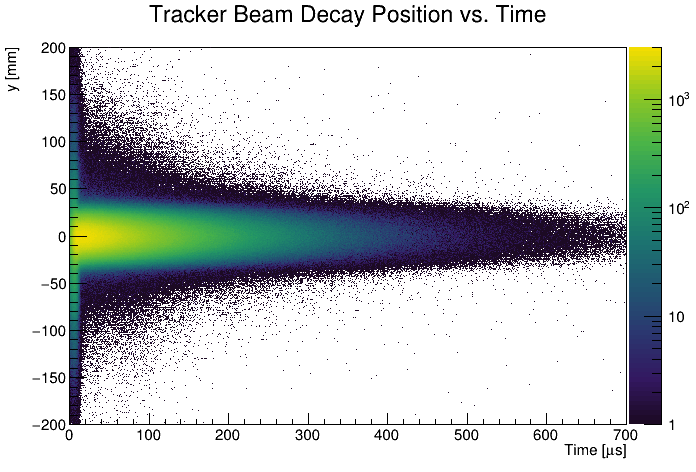

In [71]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))

hi = trackerBeamPos.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time; Time [#mus]; y [mm]")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Lets get the beam position vs. time for the selected station

In [72]:
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))
trackerBeamPos.Rebin3D(5,1,1)
widthDict = getWidths(trackerBeamPos.Project3D("yx"))

In [73]:
tlow = 10
thigh = 500
func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,0.061]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"],nFit=2)
allFitResults[name+"_beam"] = fitresult

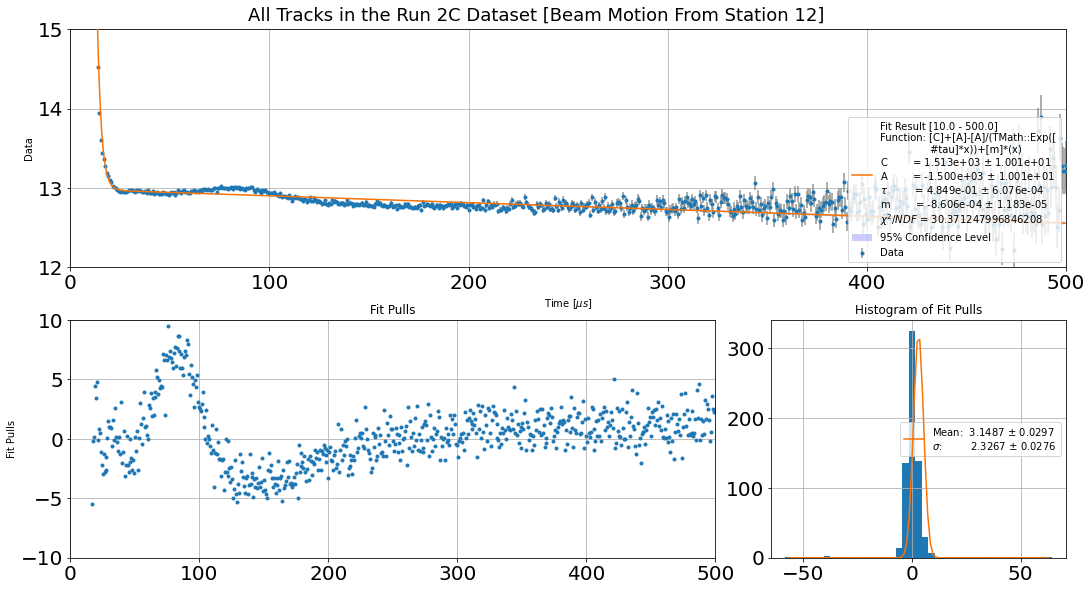

In [78]:
#fitresult.f.SetParameters(15,-170,0.00053,0.061)

fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(11,15)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_ylim(12,15)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_Beam_"+dataset+".png", bbox_inches="tight")
plt.show()

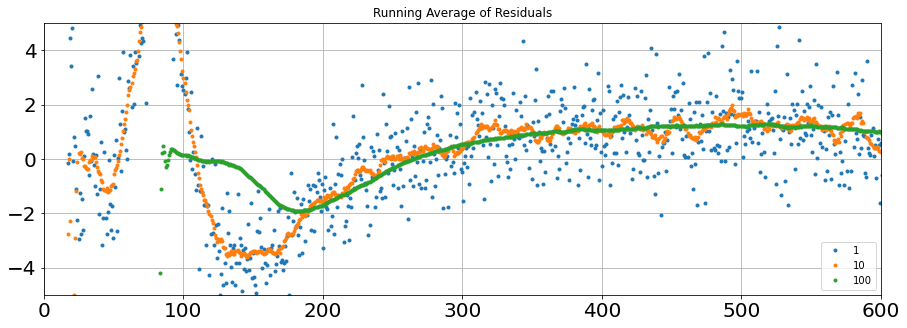

In [79]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(0,600)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [60, 300]


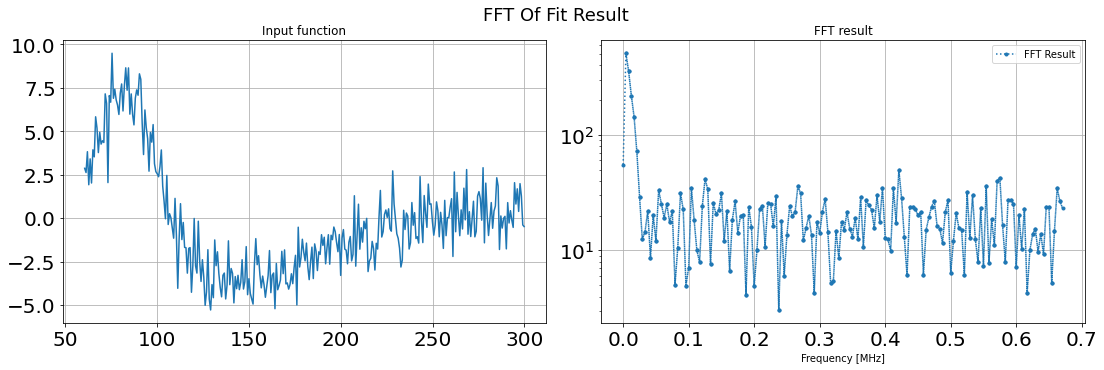

In [80]:
fitresult.fft([60,300],2)
plt.show()

---

### And the calo face position vs. time for the selected station

In [108]:
trackerCaloPos.GetZaxis().SetRange(trackerCaloPos.GetZaxis().FindBin(station),trackerCaloPos.GetZaxis().FindBin(station))
trackerCaloPos.Rebin3D(5,1,1)
widthDict = getWidths(trackerCaloPos.Project3D("yx"))

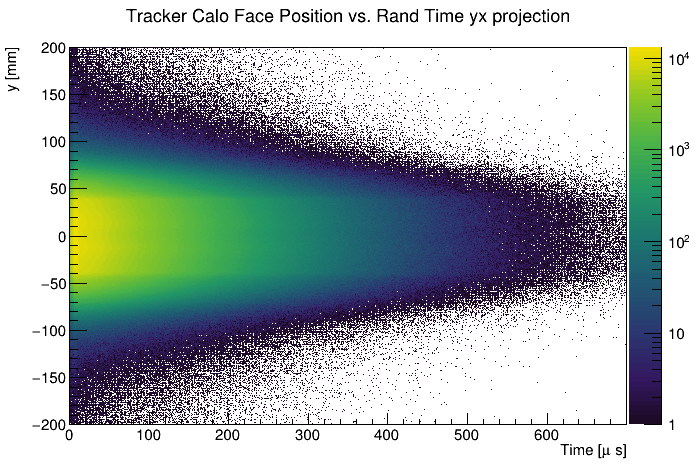

In [109]:
c = r.TCanvas()
hi = trackerCaloPos.Project3D("yx").Clone()
hi.Draw("colz")
c.SetLogz()
c.Draw()

In [114]:
tlow = 15
thigh = 550
func,paramVec = fitfunc(0, [tlow,thigh],[32, -3.5, 0.005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

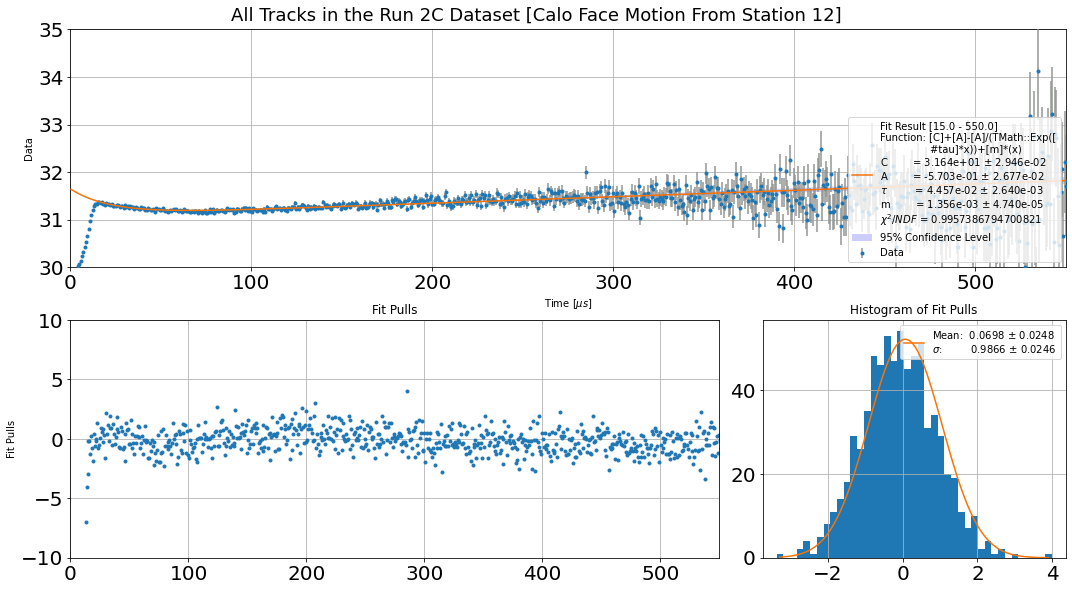

In [115]:
fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(30,35)
for i in range(2):
    ax[i].set_xlim(0,550)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_CaloFace_"+dataset+".png", bbox_inches="tight")

plt.show()

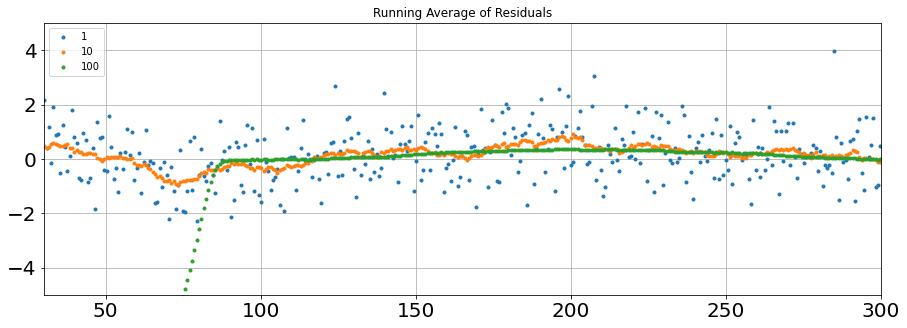

In [116]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [20, 300]


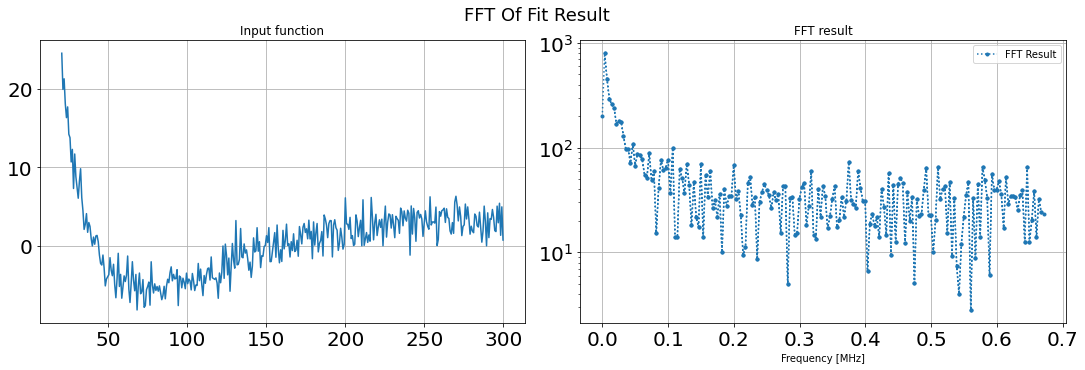

In [129]:
fitresult.fft([20,300],2)
plt.show()

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [138]:
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

trackerCaloPos_noRadialFieldRand.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station))
trackerCaloPos_noRadialFieldRand.GetYaxis().SetRangeUser(-75,75)
trackerCaloPos_noRadialFieldRand.Rebin3D(5,1,1)
widthDict = getWidths(trackerCaloPos_noRadialFieldRand.Project3D("yx"))

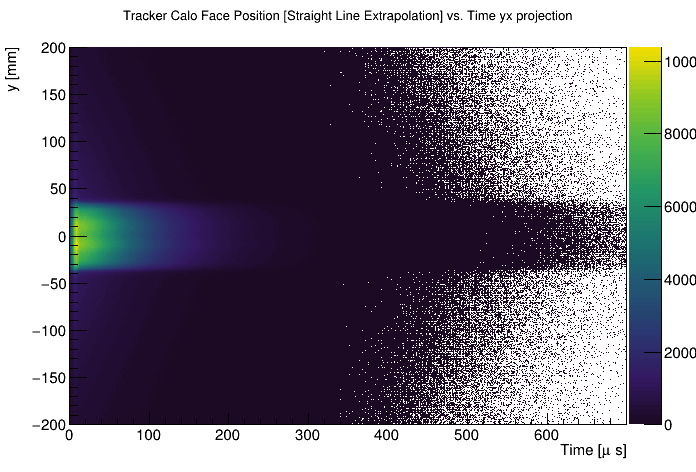

In [139]:
c = r.TCanvas()
trackerCaloPos_noRadialFieldRand.Project3D("yx").Draw("colz")
c.Draw()

In [157]:
tlow = 15
thigh = 550

func,paramVec = fitfunc(0, [tlow,thigh],[65, -3.5, 0.005, 0.005]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo_noRadialField"] = fitresult

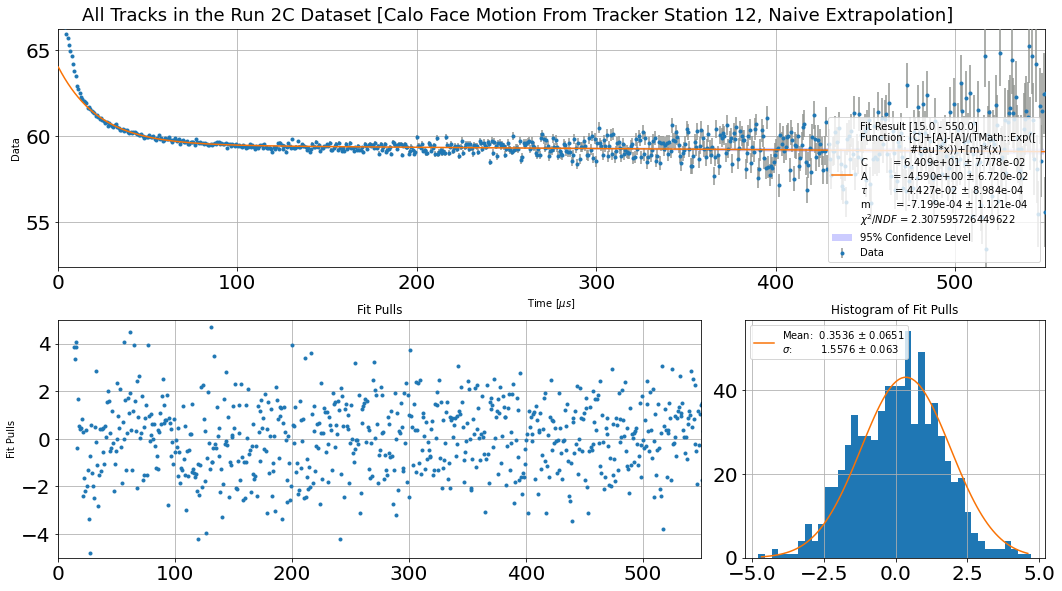

In [158]:
fig,ax = fitresult.draw(("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "
                         +str(station)+", Naive Extrapolation]"), 
                        yrange=[None, [-5,5]], fmti=".", do_pulls=True)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,550)
#ax[0].set_ylim(18,22)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllTracks_CaloFace_Naive_"+dataset+".png", bbox_inches="tight")

plt.show()

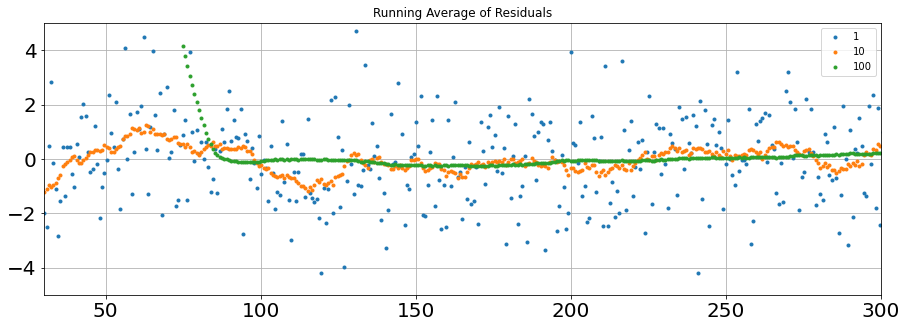

In [159]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


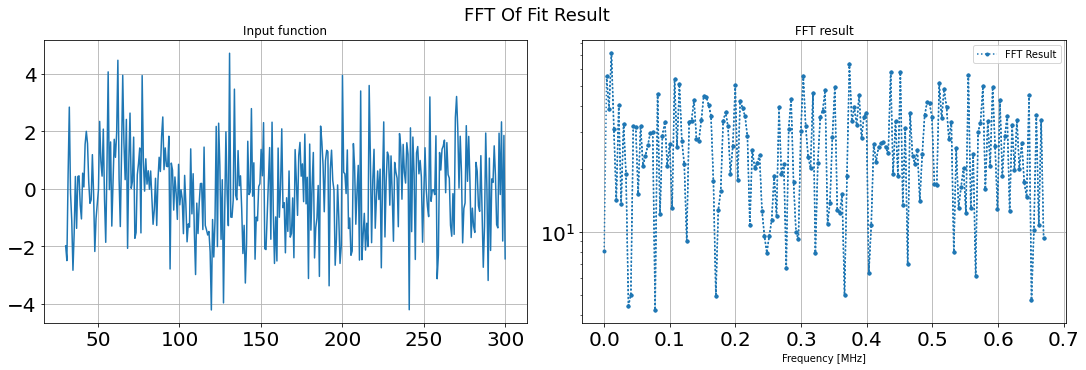

(array([ 0.        ,  0.00369776,  0.00739551,  0.01109327,  0.01479103,
         0.01848878,  0.02218654,  0.0258843 ,  0.02958205,  0.03327981,
         0.03697757,  0.04067532,  0.04437308,  0.04807084,  0.0517686 ,
         0.05546635,  0.05916411,  0.06286187,  0.06655962,  0.07025738,
         0.07395514,  0.07765289,  0.08135065,  0.08504841,  0.08874616,
         0.09244392,  0.09614168,  0.09983943,  0.10353719,  0.10723495,
         0.1109327 ,  0.11463046,  0.11832822,  0.12202597,  0.12572373,
         0.12942149,  0.13311924,  0.136817  ,  0.14051476,  0.14421251,
         0.14791027,  0.15160803,  0.15530579,  0.15900354,  0.1627013 ,
         0.16639906,  0.17009681,  0.17379457,  0.17749233,  0.18119008,
         0.18488784,  0.1885856 ,  0.19228335,  0.19598111,  0.19967887,
         0.20337662,  0.20707438,  0.21077214,  0.21446989,  0.21816765,
         0.22186541,  0.22556316,  0.22926092,  0.23295868,  0.23665643,
         0.24035419,  0.24405195,  0.2477497 ,  0.2

In [160]:
fitresult.fft([30,300],2)

---

### Difference in tracks vs time



In [161]:
trackerDeltaPosition_vs_Time = f.Get("trackerDeltaPosition_vs_Time").Clone()

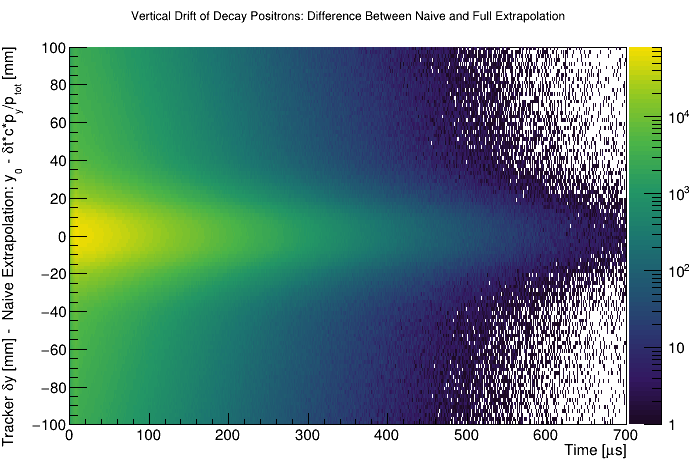

In [162]:
c = r.TCanvas()
trackerDeltaPosition_vs_Time.Draw("colz")
c.SetLogz()
c.Draw()

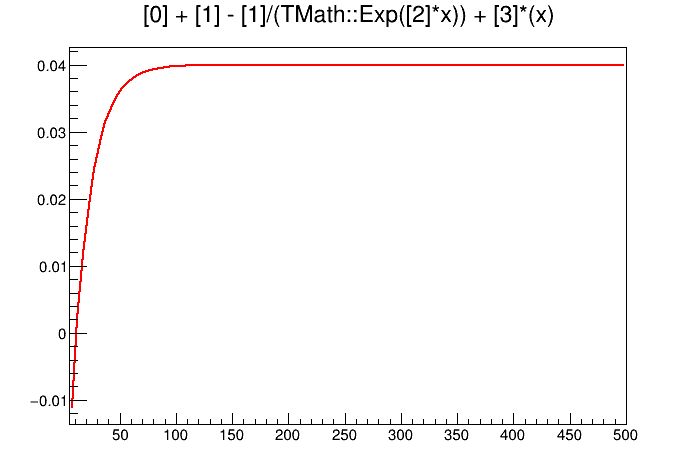

In [163]:
func = fitfunc(0,[5,500],[-0.04,0.08,0.06,0])[0]
func.Draw()
c.Draw()

Info in <TCanvas::Print>: png file ./images/outputFits/width/AllTracks_Naive_Minus_Full_Extrapolation_Run 2C.png has been created


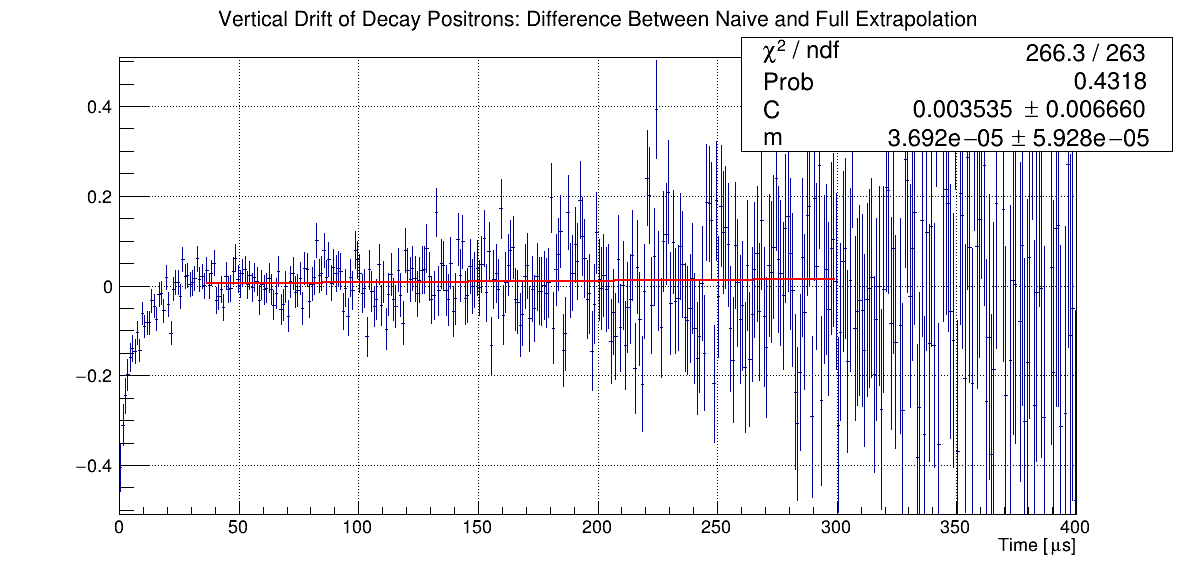

In [164]:
c = r.TCanvas("c","c",1200,600)
h2 = trackerDeltaPosition_vs_Time.ProfileX()
r.gStyle.SetOptFit(11111)
h2.Draw("")
func = fitfunc(1,[35,300],[-0.04,0.08,0.06,0])[0]
for i in range(2):
    h2.Fit(func,"REMBQ")
func.Draw("same")
h2.GetYaxis().SetRangeUser(-0.51,0.51)
h2.GetXaxis().SetRangeUser(0,400)
c.SetLogz()
c.SetGrid()
c.Print("./images/outputFits/"+to_fit+"/AllTracks_Naive_Minus_Full_Extrapolation_"+dataset+".png")
c.Draw()

---

# And now the calo only information

In [181]:
name = 'clusters'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root	
  OBJ: TH3F	clusters13	clusters : 0 at: 0x55ceb565a690
  OBJ: TH3F	randclusters13	time randomized clusters : 0 at: 0x55ceb5e89910
  KEY: TH3F	clusters13;1	clusters
  KEY: TH3F	randclusters13;1	time randomized clusters
  KEY: TH3F	clusters19;1	clusters
  KEY: TH3F	randclusters19;1	time randomized clusters


In [182]:
clusters = f.Get("clusters"+str(calo)).Clone()
randclusters = f.Get("randclusters"+str(calo)).Clone()

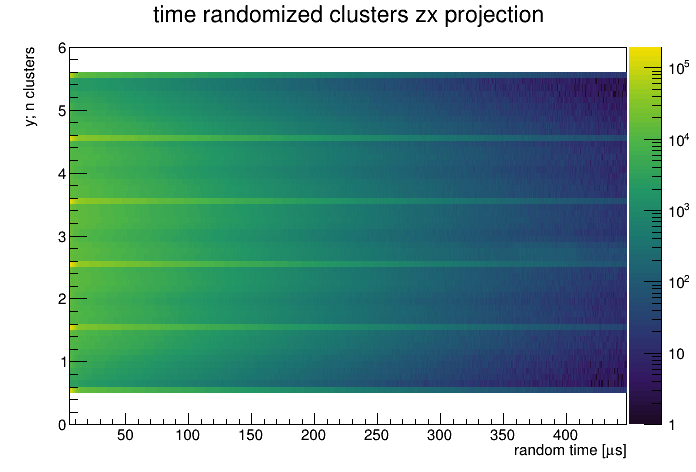

In [183]:
c = r.TCanvas()
randclusters.Project3D("zx").Draw("colz")
c.SetLogz()
c.Draw()

---
### Calo face position

In [184]:
randclusters.GetYaxis().SetRange(randclusters.GetYaxis().FindBin(1000),randclusters.GetYaxis().FindBin(2400))
#randclusters.Rebin3D(5,1,1)
widthDict = getWidths(randclusters.Project3D("zx"), scale=25, offset=3)

In [185]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

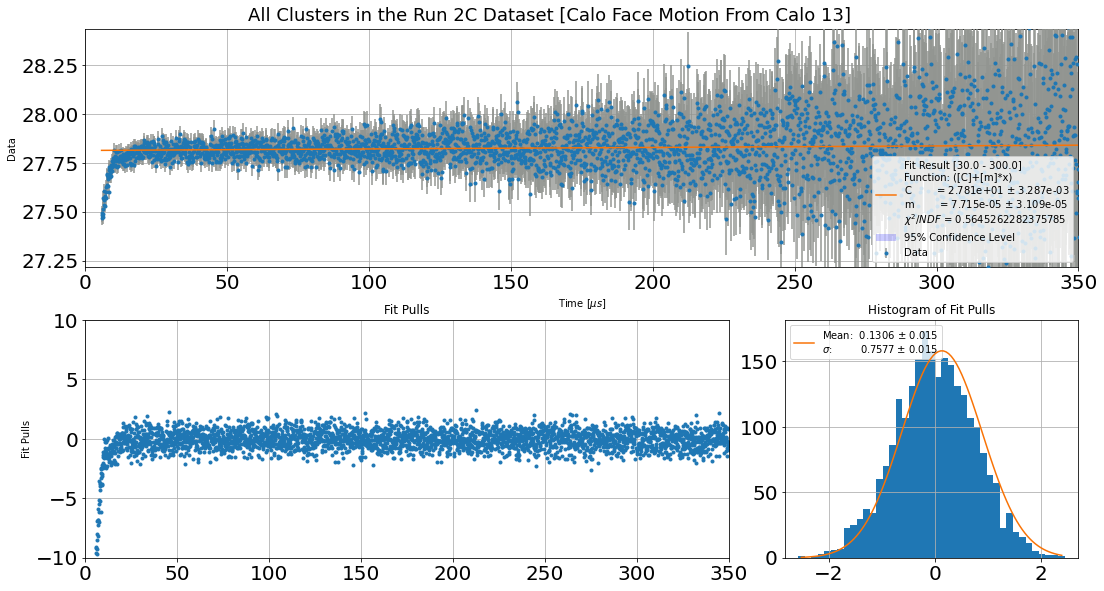

In [190]:
fig,ax = fitresult.draw("All Clusters in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(-2,30)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,350)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/AllClusters_"+dataset+".png", bbox_inches="tight")

plt.show()

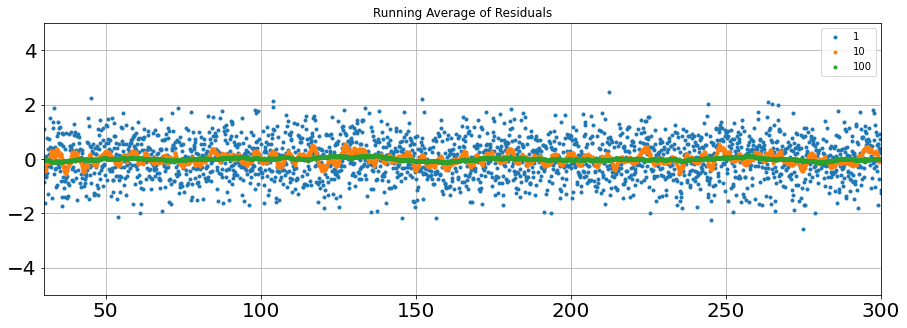

In [191]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


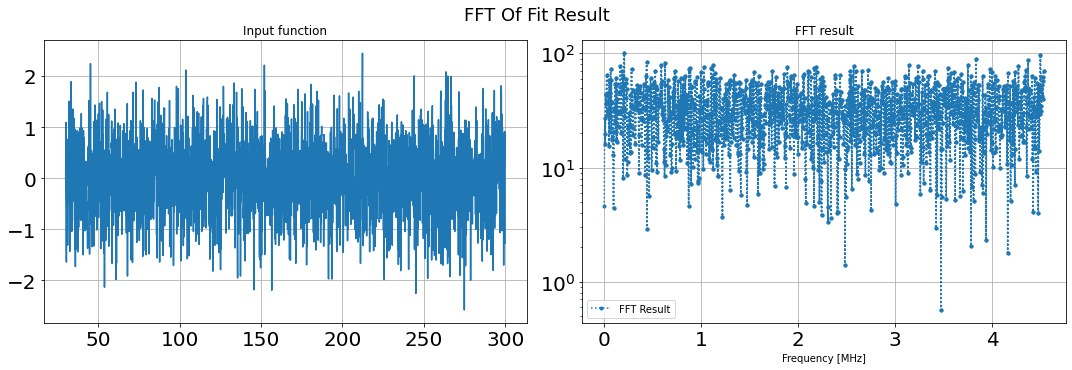

(array([ 0.        ,  0.0037032 ,  0.00740639, ..., -0.01110959,
        -0.00740639, -0.0037032 ]),
 array([  4.56470328+2.13162821e-14j,   1.68536019-1.95077271e+01j,
        -20.00400039+1.85276527e+01j, ...,  16.00109192+1.16501219e+00j,
        -20.00400039-1.85276527e+01j,   1.68536019+1.95077271e+01j]))

In [192]:
fitresult.fft([30,300],2)

---

# And finally the calo-matched information

In [193]:
name = 'matchedTracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/matchedTracks_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/matchedTracks_run2c.root	
  OBJ: TH2D	trackerBeamPosRand_yx	Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x55ceb4079b80
  OBJ: TH1D		Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x55ceb4299330
  OBJ: TH2D	trackerCaloPosRand_yx	Tracker Calo Face Position vs. Rand Time yx projection : 0 at: 0x55ceb4b503a0
  OBJ: TH2D	trackerCaloPos_noRadialFieldRand_yx	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time yx projection : 0 at: 0x55ceb5264c80
  OBJ: TProfile	trackerDeltaPosition_vs_Time_pfx	Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation : 0 at: 0x55ceb598fdd0
  OBJ: TH2D	randclusters13_zx	time randomized clusters zx projection : 0 at: 0x55ceb5a06380
  OBJ: TH3I	trackerBeamPosRand	Tracker Beam Position vs. Rand Time : 0 at: 0x55ceb4a65b60
  OBJ: TH3I	trackerCaloPosRand	Normal Extrapolati

In [194]:
trackerBeamPos_match = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos_match = f.Get("trackerCaloPosRand").Clone()
caloCaloPos_match = f.Get("caloCaloPosRand").Clone()
trackerCaloPos_noRadialField_match = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand_match = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

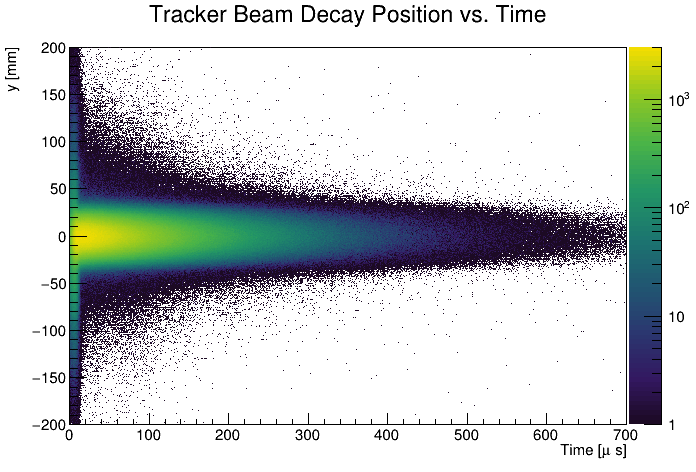

In [195]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos_match.GetZaxis().SetRange(trackerBeamPos_match.GetZaxis().FindBin(station),
                                         trackerBeamPos_match.GetZaxis().FindBin(station))

hi = trackerBeamPos_match.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Beam position vs. time

In [199]:
trackerBeamPos_match.GetZaxis().SetRange(trackerBeamPos_match.GetZaxis().FindBin(station),
                                         trackerBeamPos_match.GetZaxis().FindBin(station))
trackerBeamPos_match.Rebin3D(5,1,1)
widthDict = getWidths(trackerBeamPos_match.Project3D("yx"))

In [200]:
tlow = 30
thigh = 500

func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,0.061]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_beam"] = fitresult

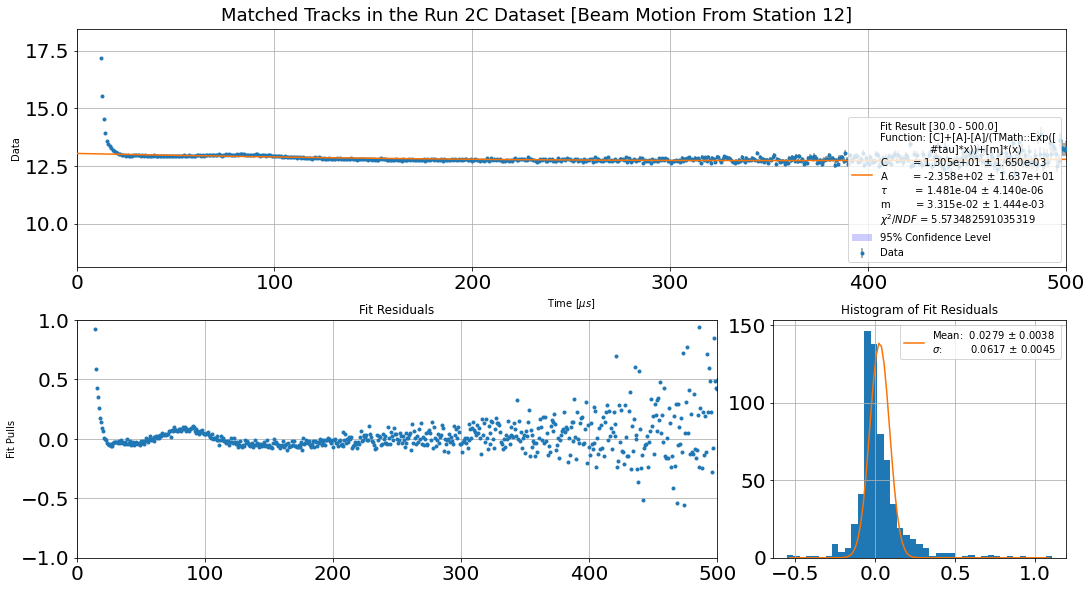

In [202]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-1,1]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_BeamMotion_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from tracker)

In [44]:
trackerCaloPos_match.GetZaxis().SetRange(trackerCaloPos_match.GetZaxis().FindBin(station),
                                         trackerCaloPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_match.Project3D("yx"))

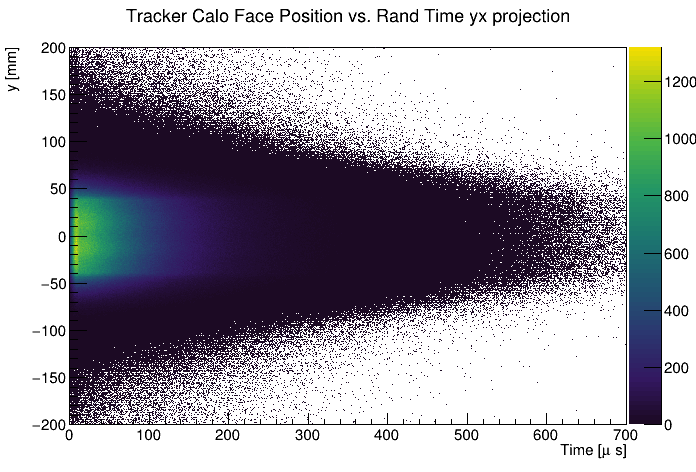

In [45]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_match.Project3D("yx").Draw("colz")
trackerCaloPos_match.SetTitle("Normal Extrapolation to Calo Face")
c.Draw()

In [46]:
tlow = 30
thigh = 500

func,paramVec = fitfunc(0, [tlow,thigh],[32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo"] = fitresult

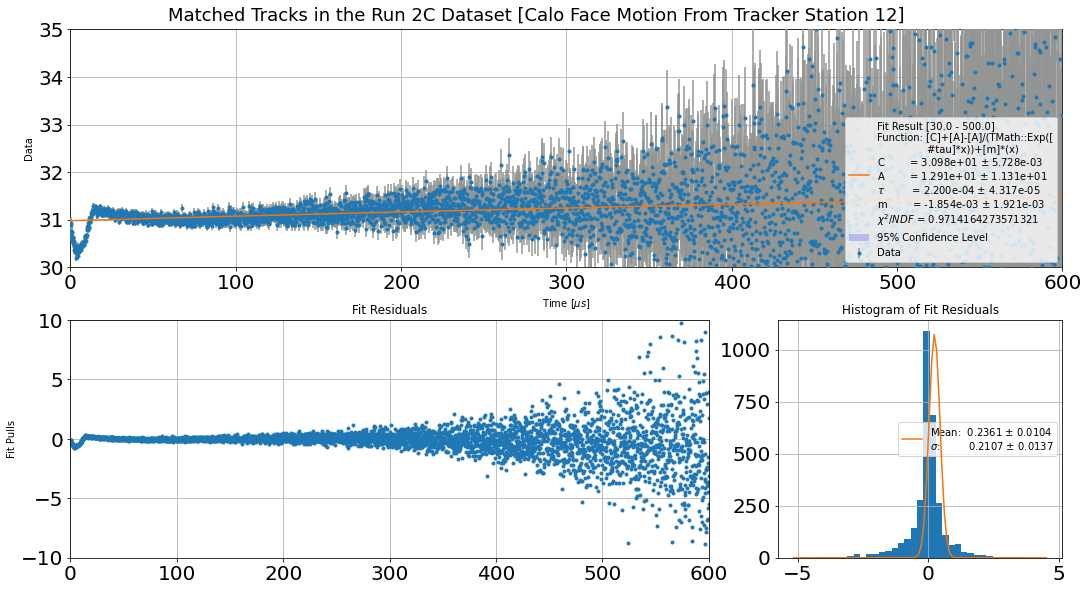

In [47]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "+str(station)+"]", 
                        yrange=[[30,35], [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,600)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_CaloFace_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [48]:
trackerCaloPos_noRadialFieldRand_match.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand_match.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand_match.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_noRadialFieldRand_match.Project3D("yx"))

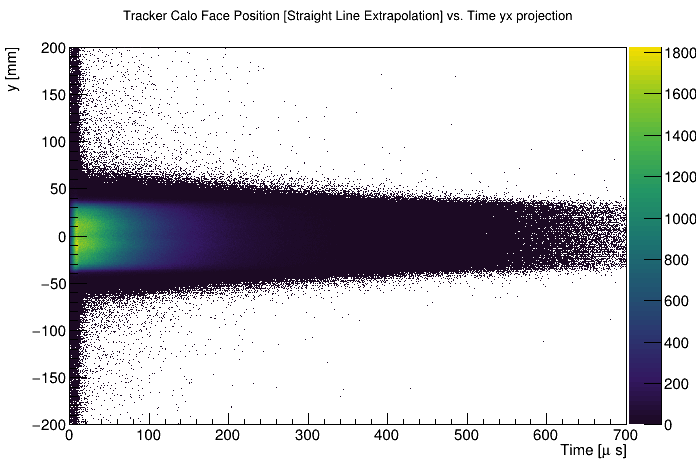

In [49]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_noRadialFieldRand_match.Project3D("yx").Draw("colz")
c.Draw()

In [50]:
tlow = 30
thigh = 600

func,paramVec = fitfunc(0, [tlow,thigh], [32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_calo_noRadialField"] = fitresult

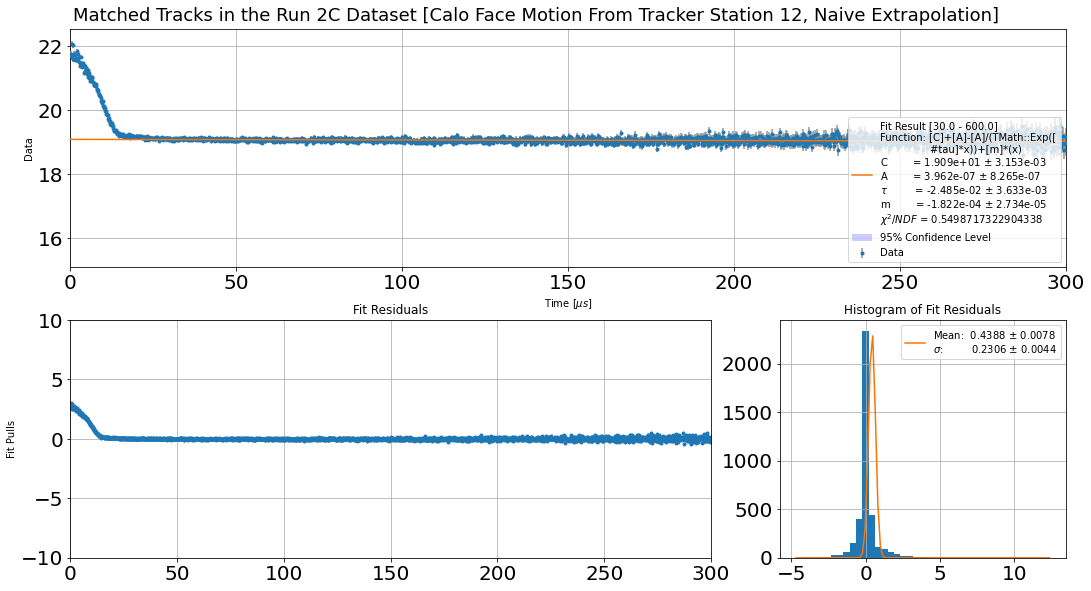

In [51]:
fig,ax = fitresult.draw("Matched Tracks in the Run 2C Dataset [Calo Face Motion From Tracker Station "+str(station)+", Naive Extrapolation]", 
                        yrange=[None, [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,300)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_CaloFace_Naive_"+dataset+".png", bbox_inches="tight")

plt.show()

---

### Calo face position vs. time (from clusters)

In [52]:
caloCaloPos_match.GetZaxis().SetRange(caloCaloPos_match.GetZaxis().FindBin(station),
                                      caloCaloPos_match.GetZaxis().FindBin(station))
widthDict = getWidths(caloCaloPos_match.Project3D("yx"))

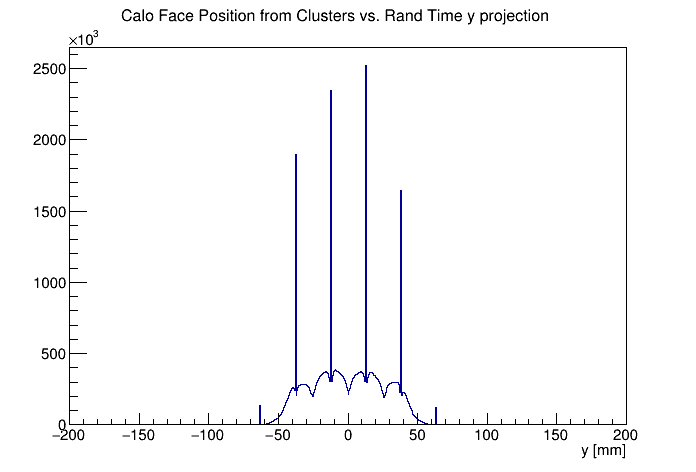

In [53]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
caloCaloPos_match.Project3D("y").Draw("colz")
c.Draw()

In [54]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict[to_fit+"s"], func, None, widthDict[to_fit+"Errs"])
allFitResults[name+"_clusters"] = fitresult

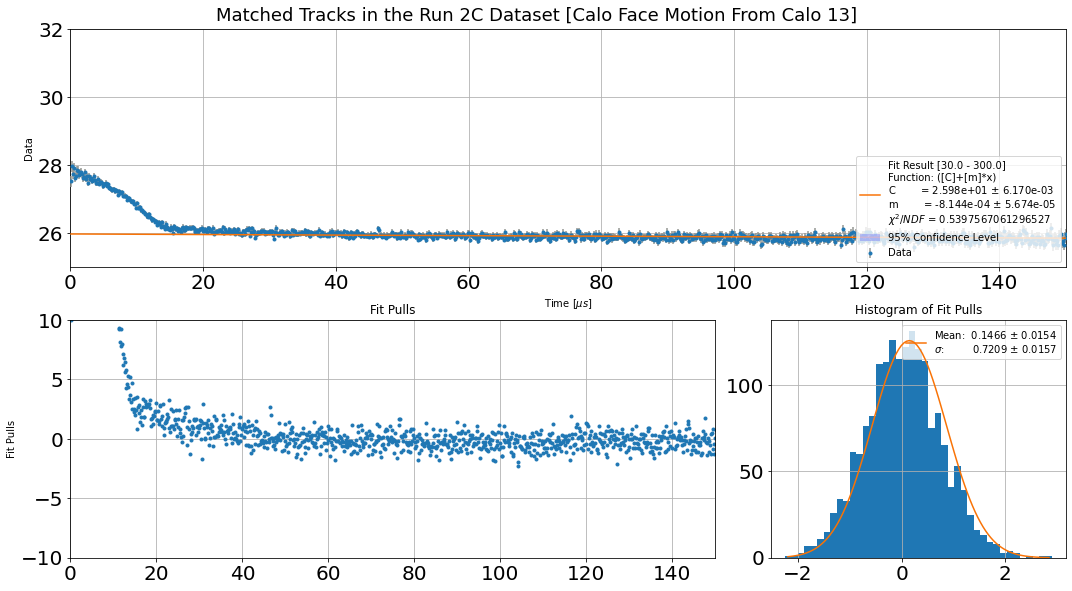

In [55]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
ax[0].set_ylim(25,32)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(0,150)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.savefig("./images/outputFits/"+to_fit+"/MatchedTracks_Clusters_"+dataset+".png", bbox_inches="tight")

plt.show()

---

# Now lets compare the fit results from these datasets